In [44]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

clean data -- create directory to hold images.

In [47]:
#directories
# directory = '/Users/jameskidd/Documents/code/facial_expression_classifier'
# face_csv_filepath = 'data/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'

In [66]:
#load csv
def face_csv_to_df(csv_pathname):
    
    directory = os.getcwd() #returns path to current directory
    try:
        #create dataframe containing image expression label number, usage, and pixels.
        facedata = pd.read_csv(os.path.join(directory, csv_pathname))
        print("Dataframe of CSV successfully created.")
    except:
        print("Issue raised creating dataframe.")
        return 0
    
    facedata.rename(columns=lambda x: x.strip())
    print(f"Columns in dataframe: {facedata.columns}")
    
    
    
    

facial_expression = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}



SyntaxError: invalid syntax (2355266364.py, line 8)

In [64]:
print(df.columns)

Index(['emotion', 'Usage', 'pixels'], dtype='object')


In [24]:
data = (df.iloc[2][0])

In [25]:
new_array = np.fromstring(data, dtype=int, sep=' ').reshape(48,48)

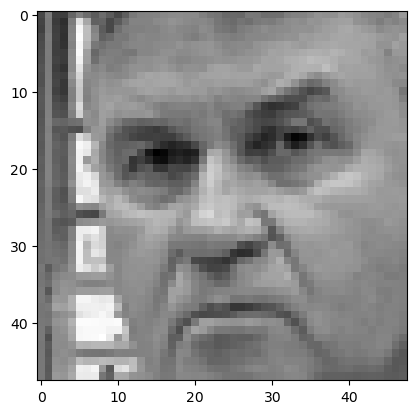

In [26]:
plt.imshow(new_array,cmap='gray')